In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from rbm.definitions import DATASET_DIR, MODEL_DIR
from rbm.tmc_utils import loadTMCsave, plot_valsing_evol, loadTMCRBM2D
from rbm.functions import ComputeProbabilityTMC2D

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float

# The name of the file to analyze. It can either be the AllParameters (indexed on the number of update) or the RBM one.
# The file should be located in MODEL_DIR 
model_name = 'RBMTrainGene.h5'


In [2]:
data = torch.tensor(np.genfromtxt(DATASET_DIR.joinpath('1kg_xtrain.d')).T, dtype=dtype, device=device).T

_, _, V = torch.svd(data.T)
proj_data = torch.mm(data.T, V).cpu()/data.shape[0]**.5

/home/nbereux/rbm/rbm/tmc_utils.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  _, tmpS, tmpV = torch.svd(torch.tensor(f["W" + str(t)], device=device))


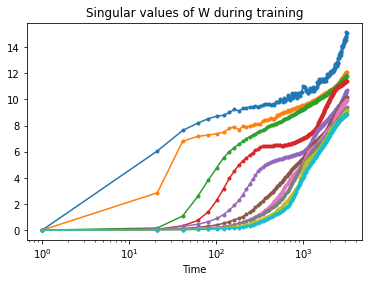

In [3]:
f, alltime = loadTMCsave(MODEL_DIR.joinpath(model_name))

nvalsing = 10 # The number of singular values to plot
S = plot_valsing_evol(f, alltime, nvalsing, scale='logx')

In [4]:
# These are all the model saved times available in the file
print(alltime)

[   1   21   41   61   81  101  121  141  161  181  201  221  241  261
  281  301  321  341  361  381  401  421  441  461  481  501  521  541
  561  581  601  621  641  661  681  701  721  741  761  781  801  821
  841  861  881  901  921  941  961  981 1001 1021 1041 1061 1081 1101
 1121 1141 1161 1181 1201 1221 1241 1261 1281 1301 1321 1341 1361 1381
 1401 1421 1441 1461 1481 1501 1521 1541 1561 1581 1601 1621 1641 1661
 1681 1701 1721 1741 1761 1781 1801 1821 1841 1861 1881 1901 1921 1941
 1961 1981 2001 2021 2041 2061 2081 2101 2121 2141 2161 2181 2201 2221
 2241 2261 2281 2301 2321 2341 2361 2381 2401 2421 2441 2461 2481 2501
 2521 2541 2561 2581 2601 2621 2641 2661 2681 2701 2721 2741 2761 2781
 2801 2821 2841 2861 2881 2901 2921 2941 2961 2981 3001 3021 3041 3061
 3081 3101 3121]


# Potential/Probability Analysis

In [5]:
# Parameters to reconstruct the probability
t = 401 # The time at which we want to compute the probability
nb_chain = 10 # nb of MC chains for each w_hat
it_mcmc = 200 # Nb of it_mcmc for each chain
it_mean = 100 # Nb of iterations to compute the mean
N = 20000 # Constraint
nb_point_dim = torch.tensor([50, 50]) # Nb of discretization points for w_hat 
border_length = 0.1
direction = torch.tensor([1, 2], device = device)


In [6]:
myRBM = loadTMCRBM2D(f, t, lr=0.1, NGibbs=10, mb_s=500, num_pcd=500, PCA=True, direction=direction, nb_point_dim=nb_point_dim, device=device, dtype=dtype)

In [7]:
square, p_m, w_hat_b = ComputeProbabilityTMC2D(myRBM, data, nb_chain, it_mcmc, it_mean, N, nb_point_dim, border_length, V, direction=direction, device=device)

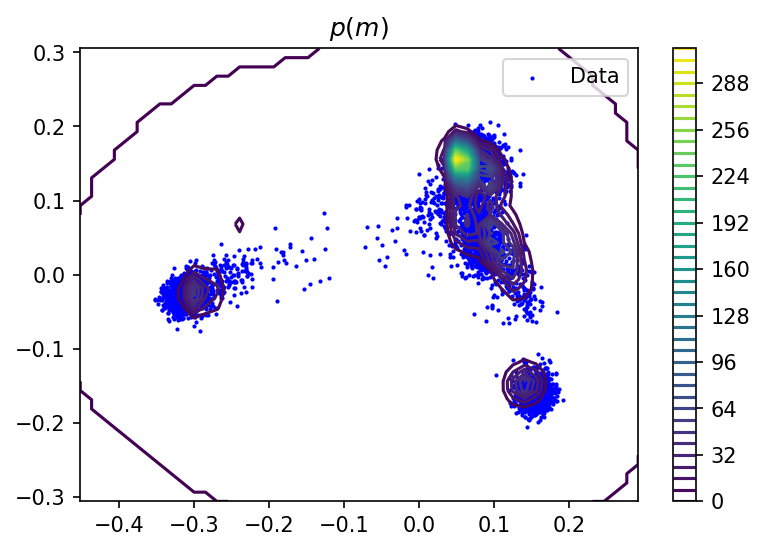

In [8]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
           , label='Data') # Plot the data
proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], p_m.cpu().numpy(), 50) # Plot the contour of the probability
ax.set_title(r'$p(m)$')
ax.legend()
fig.colorbar(proba_cont, ax=ax);

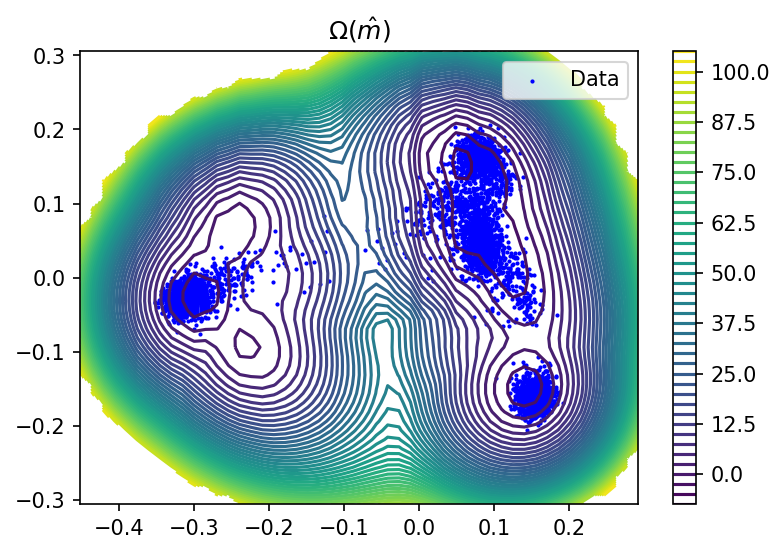

In [9]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
           , label='Data') # Plot the data
pot_cont = ax.contour(w_hat_b[0], w_hat_b[1], -torch.log(p_m).cpu().numpy(), 50) # Plot the contour of the potential
ax.set_title(r'$\Omega(\hat{m})$')
ax.legend()
fig.colorbar(pot_cont, ax=ax);

# Sampling


In [10]:
n_sample = 2000
new_sample, _ = myRBM.genDataTMC2D(n_sample, V, it_mcmc=60)

In [11]:
proj_gen =  torch.mm(new_sample.T, V)/myRBM.Nv**.5

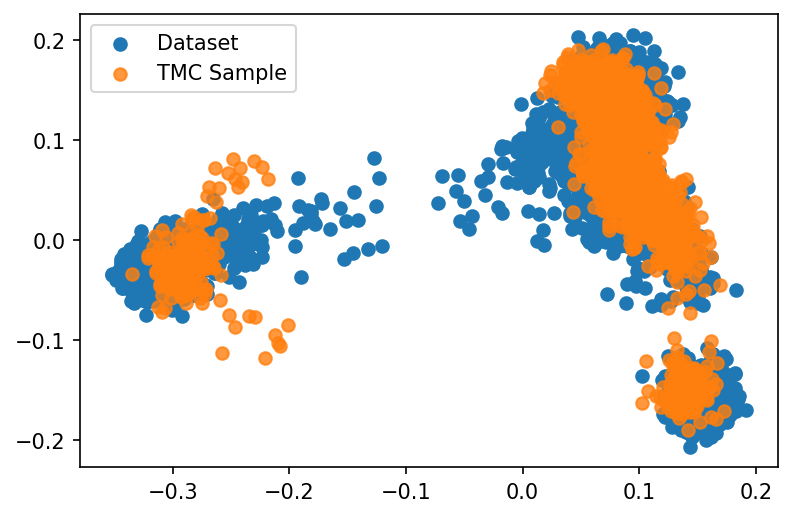

In [12]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.scatter(proj_data[:,direction[0]].cpu().numpy(), proj_data[:,direction[1]].cpu().numpy(), label='Dataset')
ax.scatter(proj_gen[:,direction[0]].cpu().numpy(), proj_gen[:,direction[1]].cpu().numpy(), label='TMC Sample', alpha=.8);
ax.legend()

If we want to sample a specific region, we can specify it to the `genDataTMC2D` method:

In [13]:
region = torch.tensor([[-0.1, 0], [-0.3, -0.2]])
new_sample_region, _ = myRBM.genDataTMC2D(n_sample, V, it_mcmc=60, region=region)

KeyboardInterrupt: 

: 

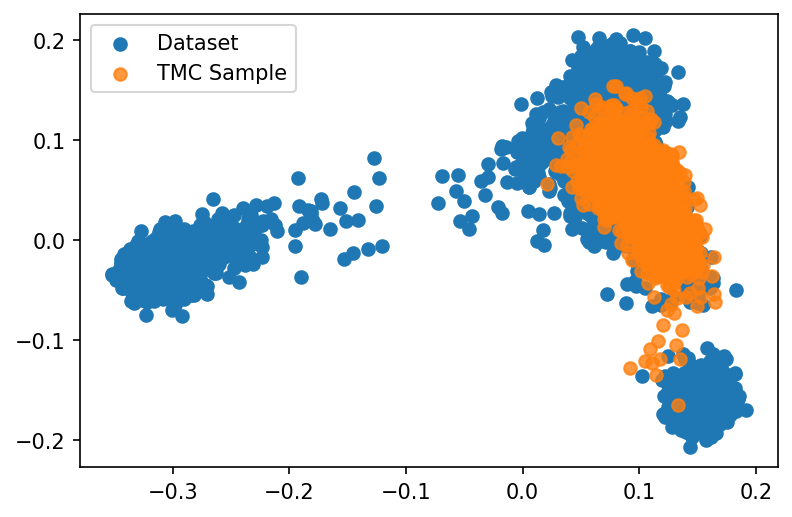

In [ ]:
proj_gen_region =  torch.mm(new_sample_region.T, V)/myRBM.Nv**.5
fig, ax = plt.subplots(1,1, dpi=150)
ax.scatter(proj_data[:,direction[0]].cpu().numpy(), proj_data[:,direction[1]].cpu().numpy(), label='Dataset')
ax.scatter(proj_gen_region[:,direction[0]].cpu().numpy(), proj_gen_region[:,direction[1]].cpu().numpy(), label='TMC Sample', alpha=.8);
ax.legend()